In [1]:
import cv2, json, ast

import numpy as np
import matplotlib.pyplot as plt
import paho.mqtt.client as mqtt

from torch.utils.data import DataLoader
from pytorch_lightning import Trainer

from anomalib.models.padim.lightning_model import PadimLightning
from anomalib.data.inference import InferenceDataset
from anomalib.pre_processing.transforms import Denormalize

c:\Users\Pablo\anaconda3\envs\anomalib_env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def load_model(root):
    checkpoint = os.listdir(root)[0]
    print(checkpoint)
    model = PadimLightning.load_from_checkpoint(f"{root}/{checkpoint}")
    trainer = Trainer(progress_bar_refresh_rate=0)
    
    return model, trainer

In [3]:
def sub_photo(host, port, topic):

    def on_connect(client, userdata, flags, rc):
        print('Connected to PHOTO '+str(rc))
        client.subscribe(topic)
        
    def on_message(client, userdata, msg):
        data = json.loads(msg.payload.decode("utf8"))

        image = str(list(data.values())[0])
        c = int(list(data.keys())[0])
        timestamp = str(list(data.values())[1])

        with open(f'./data/timestamp.txt','w') as f:
            f.write(timestamp)
        print('timestamp written')

        with open(f'./data/image_{c}.txt','w') as f:
            f.write(image)
        print('image written')
        
        if c == 2:
            client.disconnect()

    client = mqtt.Client()
    client.on_connect = on_connect
    client.on_message = on_message

    client.connect(host, port, keepalive=180)
    client.loop_forever()

    return None

In [4]:
def pub_results(model, trainer,image, host, port, topic):
    dataset = DataLoader(InferenceDataset(f"./data/webcam_images/{image}.png", image_size=tuple([288,288])))
    output = trainer.predict(model=model, dataloaders=dataset)[0]
    pred_label = str(int(output['pred_labels'].tolist()[0]))

    client = mqtt.Client()
    client.connect(host, port, keepalive=180)
    client.publish(topic, pred_label)
    #print('RESULTS published')
    return output

In [5]:
def text_to_img():
    image = np.zeros((288,288,3)) 
    timestamp = open(f'./data/timestamp.txt', "r").read()
    for channel in range(3):
        f = open(f'./data/image_{channel}.txt', "r")
        output = f.read()
        msg_list = ast.literal_eval(output)
        msg_ndar = np.asarray(msg_list)
        image[:,:,channel] = msg_ndar
    cv2.imwrite(f'./data/webcam_images/webcam_{timestamp}.png', image)
    return image, timestamp

In [3]:

port = 1883
model, trainer = load_model('./results/padim/big_50/run/weights/')

model.ckpt


c:\Users\Pablo\anaconda3\envs\anomalib_env\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Metric `PrecisionRecallCurve` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
c:\Users\Pablo\anaconda3\envs\anomalib_env\lib\site-packages\pytorch_lightning\loops\utilities.py:92: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
c:\Users\Pablo\anaconda3\envs\anomalib_env\lib\site-packages\pytorch_lightning\trainer\connectors\callback_connector.py:96: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the T

In [11]:

dataset = DataLoader(InferenceDataset(f"./que.jpg", image_size=tuple([288,288])))
output = trainer.predict(model=model, dataloaders=dataset)[0]
pred_label = str(int(output['pred_labels'].tolist()[0]))

Transform configs has not been provided. Images will be normalized using ImageNet statistics.


In [7]:
ip = "192.168.137.70"
outputs = {}

In [10]:
while True:
    sub_photo(ip, port, 'photo')
    print("Foto recibida")
    
    img, timestamp = text_to_img()
    
    #print("Publicando resultados")
    output = pub_results(model, trainer,f'webcam_{timestamp}', ip, port, 'results')
    outputs[f'webcam_{timestamp}'] = output
    print("Resultados publicados")

Connected to PHOTO 0
timestamp written
image written
timestamp written
image written
Foto recibida


Transform configs has not been provided. Images will be normalized using ImageNet statistics.
c:\Users\Pablo\anaconda3\envs\anomalib_env\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Resultados publicados
Connected to PHOTO 0


KeyboardInterrupt: 

In [11]:
def show_image(path):
    output = outputs[path]
    image = Denormalize()(output["image"][0])
    #print(f"Image Shape: {image.shape}\n Min Pixel: {image.min()} \n Max Pixel: {image.max()}")
    #plt.imshow(image)
    return image

def show_anomaly_map(path):
    output = outputs[path]
    anomaly_map = output["anomaly_maps"][0].cpu().numpy().squeeze()
    #plt.imshow(anomaly_map)
    return anomaly_map
    
def show_pred_maks(path):
    output = outputs[path]
    pred_masks = output["pred_masks"][0].squeeze().cpu().numpy()
    #plt.imshow(pred_masks)
    return pred_masks

def show_results(path):
    image = show_image(path)
    anomaly_map = show_anomaly_map(path)
    pred_masks = show_pred_maks(path)

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

    ax1.imshow(image)
    ax2.imshow(anomaly_map)
    ax3.imshow(pred_masks)

    ax1.set_title('Image')
    ax2.set_title('Anomaly map')
    ax3.set_title('Predicted masks')

    ax1.axis('off')
    ax2.axis('off')
    ax3.axis('off')

    plt.show()

In [ ]:
outputs.keys()

dict_keys(['webcam_2022_12_23_14_46_06', 'webcam_2022_12_23_14_57_30', 'webcam_2022_12_23_15_34_17', 'webcam_2022_12_23_15_34_30', 'webcam_2022_12_23_15_34_41', 'webcam_2022_12_23_15_34_52', 'webcam_2022_12_23_16_34_17', 'webcam_2022_12_23_16_35_46'])

C:\Users\Pablo\anomalib\anomalib\pre_processing\transforms\custom.py:23: UserWarning: Denormalize is no longer used and will be deprecated in v0.4.0
  warnings.warn("Denormalize is no longer used and will be deprecated in v0.4.0")


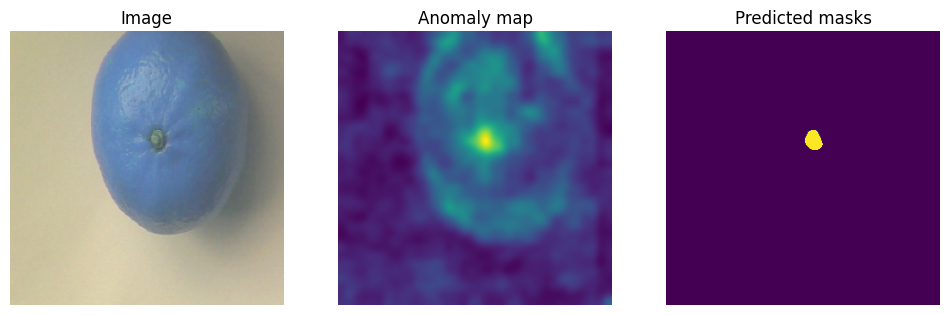

In [12]:
path = list(outputs.keys())[-1]
show_results(path)